# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 2:</center>
### <center> Propiedades en Venta </center>
### <center>  Grupo 18</center>


#### **Integrantes:**

* Analía Acevedo
* Santiago Daniel Marczewski Neudeck
* Lucia Belén Napoli
* Brayan Ricaldi

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.preprocessing as skp

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
from preprocessing import preprocesamiento

from sklearn.model_selection import RandomizedSearchCV
from joblib import dump, load

pd.options.display.max_columns = None

from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,  recall_score, precision_score, accuracy_score
from sklearn.datasets import make_classification
from collections import defaultdict
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

import plotly.graph_objects as go
%matplotlib inline


from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import tensorflow as tfa
from tensorflow import keras
import keras_tuner as kt
import visualkeras
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K

np.random.seed(1)
tf.random.set_seed(1)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

/home/lucia/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
2022-12-08 21:21:31.206501: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 21:21:31.392682: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-08 21:21:31.392708: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on 

Descargo los datos

In [2]:
_x_train_model = pd.read_csv('./DataSet/x_train')
_x_train_model.drop(columns=['Unnamed: 0'],inplace=True)

_y_train_model = pd.read_csv('./DataSet/y_train')
_y_train_model.drop(columns=['Unnamed: 0'],inplace=True)

_x_test_model = pd.read_csv('./DataSet/x_test')
_x_test_model.drop(columns=['Unnamed: 0'],inplace=True)

_y_test_model = pd.read_csv('./DataSet/y_test')
_y_test_model.drop(columns=['Unnamed: 0'],inplace=True)

_y_train_model.rename(columns={'0':'pxm2'}, inplace=True)
_y_test_model.rename(columns={'0':'pxm2'}, inplace=True)

# Redes neuronales

Construir dos modelos de redes neuronales, uno para regresión y otro para clasificación,
considerando los datasets creados en el TP1. Mejorar estos modelos de redes
neuronales a través de la búsqueda de arquitectura e hiperparámetros adecuados. Se
pide:

● Regresión: predecir el precio de la propiedad y utilizar como métrica de
evaluación el error cuadrático medio.

● Clasificación: predecir el atributo tipo_precio creado en el TP 1 y utilizar como
métricas precisión, recall y F1-Score.


# Modelo de Redes Neuronales para clasificación

Los hiperparametros a buscar son los siguientes:

- **Función de activación:** Vamos a usar relu y softmax
- **Cantidad de capas:** Es la cantidad de capas que tendrá la red neuronal. Tendremos una capa input, 1 oculta y una capa de salida.
- **Cantidad de neuronas por capa:** Tendremos tres neuronas en la capa de salida porque son tres las clases que queremos predecir: alto, medio y bajo. En la capa de entrada tendremos 8 neuronas, la cantidad de features que tiene el dataset.
- **Optimizador:** Un optimizador es una implementación concreta del algoritmo de descenso por gradiente dentro de backpropagation.
    - SGD (Stochastic Gradient Descent): Backpropagation simple, sin ningún tipo de optimización. 
    - Adam (Adaptive moment estimation): Hace un seguimiento de una media de decaimiento exponencial de gradientes pasados y de gradientes cuadrados pasados.
- **Loss function o función de perdida:** Es la función utilizada por el optimizador para minimizar. Usaremos categorical_crossentropy.
- **Learning rate o tasa de aprendizaje:** Indica qué tan rápido se va descediendo en la función de costo, qué tan rápido va acercandose al minimo local o global.
- **Metricas:** Se van calculando en cada iteracion o batch. Utilizaremos precision, recall y F1-Score
- **Cantidad de epochs:** Es la cantidad de iteraciones que tendrá el entrenamiento. En este caso 100.

Defino funciones:

In [3]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Ejecutamos una copia de los modelos

In [4]:
x_train = _x_train_model.copy()
y_train = _y_train_model.copy()
x_test = _x_test_model.copy()
y_test = _y_test_model.copy()

Clasifico mi target

In [5]:
labels=["bajo","medio","alto"]
new_target_train, bins = pd.qcut(y_train['pxm2'],q=[0,0.25,0.75,1], labels=labels, retbins=True)

Reflejo la clasificacion en el test

In [6]:
bins[0] = min(y_test['pxm2']) - 1
bins[3] = max(y_test['pxm2']) + 1

In [7]:
new_target_test = pd.cut(y_test['pxm2'], bins=bins, labels=labels, include_lowest=True)

In [8]:
y_train = new_target_train
y_test = new_target_test

In [9]:
x_train.head()

,latitud,longitud,ambientes,dormitorios,superficie_cubierta,comuna,Departamento,PH
0,-34.583010,-58.481533,4.0,3.0,70.0,15,1.0,0.0
1,-34.660079,-58.485894,6.0,4.0,275.0,9,0.0,0.0
2,-34.581856,-58.425088,3.0,2.0,97.0,14,1.0,0.0
3,-34.607547,-58.442194,2.0,1.0,42.0,6,1.0,0.0
4,-34.607416,-58.509680,2.0,1.0,38.0,11,1.0,0.0


In [10]:
y_train.head()

0     alto
1     bajo
2    medio
3     bajo
4     alto
Name: pxm2, dtype: category
Categories (3, object): ['bajo' < 'medio' < 'alto']

Aplicamos one hot encoding en el target

In [11]:
# One hot encoding
enc = OneHotEncoder()
y_train_encoder = enc.fit_transform(y_train[:, np.newaxis]).toarray()
y_test_encoder = enc.transform(y_test[:, np.newaxis]).toarray()

In [12]:
y_train_encoder[0:5]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]])

Estandarizo los datos

In [14]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [15]:
x_train_scaled[0:5]

array([[ 0.50172268, -1.12215239,  0.89519544,  1.11266314, -0.0867647 ,
         1.27157065,  0.40756802, -0.34041477],
       [-2.41244287, -1.23741004,  2.38416976,  2.11040252,  3.24390971,
         0.04401013, -2.45357818, -0.34041477],
       [ 0.54533212,  0.36963696,  0.15070829,  0.11492376,  0.35190949,
         1.06697723,  0.40756802, -0.34041477],
       [-0.42611094, -0.08247136, -0.59377887, -0.88281562, -0.54168608,
        -0.56977013,  0.40756802, -0.34041477],
       [-0.42116132, -1.86603329, -0.59377887, -0.88281562, -0.60667485,
         0.45319697,  0.40756802, -0.34041477]])

Cantidad de capas de entrada y salida

In [16]:
cant_clases = len(np.unique(y_train))

d_in = len(x_train.columns.tolist())

## Modelo: Cross validation

Analizamos con cross validation que valor de learning rate y la cantidad de neuronas de la segunda capa que nos dan un mejor resultado.

In [18]:
def create_model(lr, neurona):
    
    modelo = keras.Sequential([
    keras.layers.Dense(8,input_shape=(d_in,), activation='relu'),
    keras.layers.Dense(neurona, activation='relu'),
    keras.layers.Dense(cant_clases, activation='softmax')])
    
        
    modelo.compile(
      optimizer=keras.optimizers.SGD(learning_rate=lr), 
      loss='categorical_crossentropy', 
      metrics=['accuracy'],
    )
    
    return modelo

In [19]:
modelo_cv = KerasClassifier(build_fn=create_model, epochs=100, batch_size=20, verbose=2)

In [20]:
lr = [0.001, 0.01]
neurona = [4, 5]

param_grid = dict(lr=lr, neurona=neurona)

grid = GridSearchCV(estimator=modelo_cv, param_grid=param_grid, verbose=10)
grid_result = grid.fit(x_train_scaled, y_train_encoder)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START lr=0.001, neurona=4.........................................
Epoch 1/100


2022-12-08 15:43:05.867582: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-08 15:43:05.867624: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-08 15:43:05.867662: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lucia-UbuntuNotebook): /proc/driver/nvidia/version does not exist
2022-12-08 15:43:05.868310: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2326/2326 - 3s - loss: 1.0666 - accuracy: 0.4822 - 3s/epoch - 1ms/step
Epoch 2/100
2326/2326 - 3s - loss: 0.9585 - accuracy: 0.5581 - 3s/epoch - 1ms/step
Epoch 3/100
2326/2326 - 3s - loss: 0.9195 - accuracy: 0.5767 - 3s/epoch - 1ms/step
Epoch 4/100
2326/2326 - 3s - loss: 0.8953 - accuracy: 0.5867 - 3s/epoch - 1ms/step
Epoch 5/100
2326/2326 - 3s - loss: 0.8780 - accuracy: 0.5919 - 3s/epoch - 1ms/step
Epoch 6/100
2326/2326 - 3s - loss: 0.8667 - accuracy: 0.5958 - 3s/epoch - 1ms/step
Epoch 7/100
2326/2326 - 3s - loss: 0.8597 - accuracy: 0.5969 - 3s/epoch - 1ms/step
Epoch 8/100
2326/2326 - 3s - loss: 0.8549 - accuracy: 0.5987 - 3s/epoch - 1ms/step
Epoch 9/100
2326/2326 - 3s - loss: 0.8511 - accuracy: 0.6005 - 3s/epoch - 1ms/step
Epoch 10/100
2326/2326 - 3s - loss: 0.8479 - accuracy: 0.6018 - 3s/epoch - 1ms/step
Epoch 11/100
2326/2326 - 3s - loss: 0.8454 - accuracy: 0.6030 - 3s/epoch - 1ms/step
Epoch 12/100
2326/2326 - 3s - loss: 0.8431 - accuracy: 0.6042 - 3s/epoch - 1ms/step
Epoch 13/100


In [21]:
print("Mejor modelo: %f %s" % (grid_result.best_score_, grid_result.best_params_))

Mejor modelo: 0.634855 {'lr': 0.01, 'neurona': 5}


Como podemos ver el mejor resultado que obtenemos ocurre si en la segunda capa tenemos 5 neuronas y si usamos un learning rate igual a 0.01

In [38]:
dump(modelo_cv, './Modelos_TP2/RedesNeuronalesClasificacionCV.joblib')

['./Modelos_TP2/RedesNeuronalesClasificacionCV.joblib']

## Modelo 1

Pruebo el modelo con 5 neuronas en la segunda capa y con un valor de 0.1 en el learning rate.

In [16]:
modelo_1 = keras.Sequential([
    
    keras.layers.Dense(8,input_shape=(d_in,), activation='relu',kernel_initializer='uniform'),
    
    keras.layers.Dense(5, activation='relu'),
    
    keras.layers.Dense(cant_clases, activation='softmax')])

modelo_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 5)                 45        
                                                                 
 dense_2 (Dense)             (None, 3)                 18        
                                                                 
Total params: 135
Trainable params: 135
Non-trainable params: 0
_________________________________________________________________


2022-12-08 20:34:43.195328: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-08 20:34:43.195368: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-08 20:34:43.195406: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lucia-UbuntuNotebook): /proc/driver/nvidia/version does not exist
2022-12-08 20:34:43.195765: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
modelo_1.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.01), 
  loss='categorical_crossentropy', 
  metrics=[precision_m, recall_m, f1_m], 
)

In [19]:
cant_epochs=100

historia_modelo_1 = modelo_1.fit(x_train_scaled,y_train_encoder,epochs=cant_epochs,batch_size=20, verbose=2)

Epoch 1/100
2907/2907 - 4s - loss: 0.8452 - precision_m: 0.6126 - recall_m: 0.5324 - f1_m: 0.5685 - 4s/epoch - 1ms/step
Epoch 2/100
2907/2907 - 4s - loss: 0.8258 - precision_m: 0.6376 - recall_m: 0.5482 - f1_m: 0.5882 - 4s/epoch - 1ms/step
Epoch 3/100
2907/2907 - 4s - loss: 0.8173 - precision_m: 0.6390 - recall_m: 0.5580 - f1_m: 0.5946 - 4s/epoch - 1ms/step
Epoch 4/100
2907/2907 - 4s - loss: 0.8137 - precision_m: 0.6375 - recall_m: 0.5650 - f1_m: 0.5980 - 4s/epoch - 1ms/step
Epoch 5/100
2907/2907 - 4s - loss: 0.8106 - precision_m: 0.6384 - recall_m: 0.5662 - f1_m: 0.5991 - 4s/epoch - 1ms/step
Epoch 6/100
2907/2907 - 5s - loss: 0.8073 - precision_m: 0.6380 - recall_m: 0.5710 - f1_m: 0.6017 - 5s/epoch - 2ms/step
Epoch 7/100
2907/2907 - 5s - loss: 0.8048 - precision_m: 0.6386 - recall_m: 0.5689 - f1_m: 0.6007 - 5s/epoch - 2ms/step
Epoch 8/100
2907/2907 - 4s - loss: 0.8034 - precision_m: 0.6388 - recall_m: 0.5718 - f1_m: 0.6025 - 4s/epoch - 1ms/step
Epoch 9/100
2907/2907 - 4s - loss: 0.802

In [20]:
epochs = range(cant_epochs)

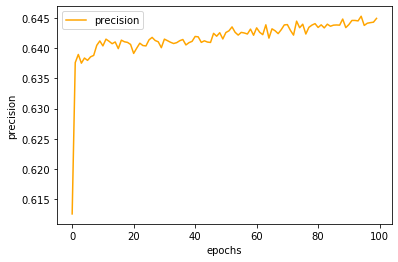

In [21]:
plt.plot(epochs, historia_modelo_1.history['precision_m'], color='orange', label='precision')
plt.xlabel("epochs")
plt.ylabel("precision")
plt.legend()

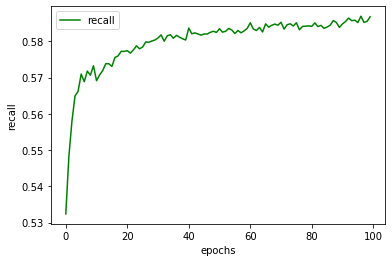

In [22]:
plt.plot(epochs, historia_modelo_1.history['recall_m'], color='green', label='recall')
plt.xlabel("epochs")
plt.ylabel("recall")
plt.legend()

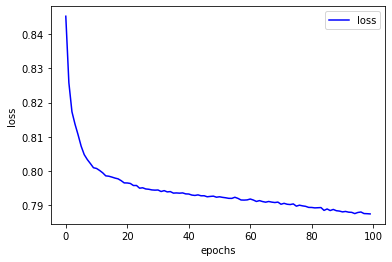

In [23]:
plt.plot(epochs, historia_modelo_1.history['loss'], color='blue', label='loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

In [28]:
modelo_1.evaluate(x_test_scaled,y_test_encoder)

455/455 [==============================] - 1s 2ms/step - loss: 2.4405 - precision_m: 0.5245 - recall_m: 0.5164 - f1_m: 0.5204


[2.4404966831207275, 0.5244983434677124, 0.516391932964325, 0.5203532576560974]

In [24]:
y_predic = modelo_1.predict(x_test_scaled)

455/455 [==============================] - 1s 2ms/step


In [25]:
y_predic[0:5]

array([[3.8167065e-01, 7.6194578e-07, 6.1832857e-01],
       [5.4163053e-03, 8.1521384e-06, 9.9457550e-01],
       [2.7451318e-02, 4.3741998e-01, 5.3512865e-01],
       [1.6894971e-03, 2.1076533e-03, 9.9620283e-01],
       [7.8950904e-02, 5.3455383e-01, 3.8649532e-01]], dtype=float32)

In [26]:
#Arbol Reporte y Matriz de Confusion
y_predic1=np.argmax(y_predic,axis=1)
y_test_encoder1=np.argmax(y_test_encoder,axis=1)

print(classification_report(y_test_encoder1,y_predic1))

              precision    recall  f1-score   support

           0       0.80      0.03      0.05      3438
           1       0.39      0.13      0.19      3660
           2       0.53      0.95      0.68      7436

    accuracy                           0.52     14534
   macro avg       0.57      0.37      0.31     14534
weighted avg       0.56      0.52      0.41     14534



In [27]:
print('Accuracy: {}'.format(accuracy_score(y_test_encoder1, y_predic1))) 
print('Precision: {}'.format(precision_score(y_test_encoder1, y_predic1, average= 'micro'))) 
print('Recall: {}'.format(recall_score(y_test_encoder1, y_predic1, average= 'micro'))) 
print('F1-Score: {}'.format(f1_score(y_test_encoder1, y_predic1, average= 'micro'))) 

Accuracy: 0.5226365763038393
Precision: 0.5226365763038393
Recall: 0.5226365763038393
F1-Score: 0.5226365763038393


In [29]:
dump(modelo_1, './Modelos_TP2/RedesNeuronalesClasificacion1.joblib')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
......mean_metric_wrapper_1
.........vars
............0
............1
......mean_metric_wrapper_2
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
...vars
Keras model archive saving:
File Name                                             Modified             Size
variables.h5                                   2022-12-08 20:47:53        28168
config.json                                    2022-12-08 20:47:53         2546
metadata.json                                  2022-12-08 20:47:53           64


['./Modelos_TP2/RedesNeuronalesClasificacion1.joblib']

## Modelo 2

Pruebo si incrementando la cantidad de neuronas en la segunda capa mejora los resultados

In [18]:
modelo_2 = keras.Sequential([
    
    keras.layers.Dense(8,input_shape=(d_in,), activation='relu',kernel_initializer='uniform'),
    
    keras.layers.Dense(6, activation='relu'),
    
    keras.layers.Dense(cant_clases, activation='softmax')])

modelo_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 6)                 54        
                                                                 
 dense_2 (Dense)             (None, 3)                 21        
                                                                 
Total params: 147
Trainable params: 147
Non-trainable params: 0
_________________________________________________________________


2022-12-08 14:31:59.210987: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-08 14:31:59.211026: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-08 14:31:59.211051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lucia-UbuntuNotebook): /proc/driver/nvidia/version does not exist
2022-12-08 14:31:59.211329: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
modelo_2.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.01), 
  loss='categorical_crossentropy', 
  metrics=[precision_m, recall_m, f1_m], 
)

In [21]:
cant_epochs=100

historia_modelo_2 = modelo_2.fit(x_train_scaled,y_train_encoder,epochs=cant_epochs,batch_size=20, verbose=2)

Epoch 1/100
2907/2907 - 4s - loss: 0.8211 - precision_m: 0.6387 - recall_m: 0.5435 - f1_m: 0.5860 - 4s/epoch - 1ms/step
Epoch 2/100
2907/2907 - 4s - loss: 0.8119 - precision_m: 0.6409 - recall_m: 0.5565 - f1_m: 0.5946 - 4s/epoch - 1ms/step
Epoch 3/100
2907/2907 - 4s - loss: 0.8057 - precision_m: 0.6394 - recall_m: 0.5635 - f1_m: 0.5980 - 4s/epoch - 1ms/step
Epoch 4/100
2907/2907 - 4s - loss: 0.8018 - precision_m: 0.6399 - recall_m: 0.5699 - f1_m: 0.6019 - 4s/epoch - 1ms/step
Epoch 5/100
2907/2907 - 4s - loss: 0.7995 - precision_m: 0.6398 - recall_m: 0.5698 - f1_m: 0.6018 - 4s/epoch - 1ms/step
Epoch 6/100
2907/2907 - 4s - loss: 0.7981 - precision_m: 0.6395 - recall_m: 0.5724 - f1_m: 0.6032 - 4s/epoch - 1ms/step
Epoch 7/100
2907/2907 - 4s - loss: 0.7966 - precision_m: 0.6403 - recall_m: 0.5709 - f1_m: 0.6026 - 4s/epoch - 1ms/step
Epoch 8/100
2907/2907 - 4s - loss: 0.7955 - precision_m: 0.6414 - recall_m: 0.5735 - f1_m: 0.6046 - 4s/epoch - 1ms/step
Epoch 9/100
2907/2907 - 4s - loss: 0.794

In [22]:
epochs = range(cant_epochs)

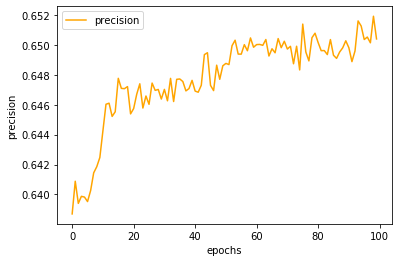

In [23]:
plt.plot(epochs, historia_modelo_2.history['precision_m'], color='orange', label='precision')
plt.xlabel("epochs")
plt.ylabel("precision")
plt.legend()

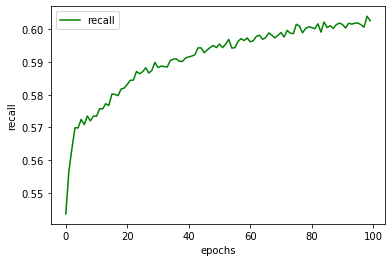

In [25]:
plt.plot(epochs, historia_modelo_2.history['recall_m'], color='green', label='recall')
plt.xlabel("epochs")
plt.ylabel("recall")
plt.legend()

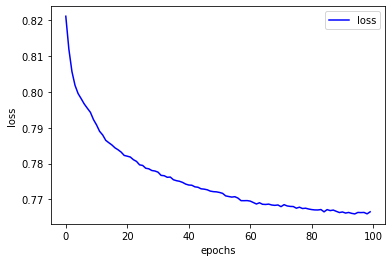

In [26]:
plt.plot(epochs, historia_modelo_2.history['loss'], color='blue', label='loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

In [31]:
y_predic = modelo_2.predict(x_test_scaled)

455/455 [==============================] - 1s 2ms/step


In [32]:
y_predic[0:5]

array([[9.99999940e-01, 1.15384474e-17, 6.30122421e-15],
       [9.99999344e-01, 3.24116115e-07, 1.98765974e-07],
       [2.44754218e-02, 7.17208743e-01, 2.58315891e-01],
       [2.34974572e-03, 9.95304704e-01, 2.34553334e-03],
       [1.03129372e-01, 4.15963978e-01, 4.80906725e-01]], dtype=float32)

In [33]:
#Arbol Reporte y Matriz de Confusion
y_predic1=np.argmax(y_predic,axis=1)
y_test_encoder1=np.argmax(y_test_encoder,axis=1)

print(classification_report(y_test_encoder1,y_predic1))

              precision    recall  f1-score   support

           0       0.33      0.63      0.44      3438
           1       0.34      0.66      0.45      3660
           2       0.57      0.07      0.13      7436

    accuracy                           0.35     14534
   macro avg       0.41      0.45      0.34     14534
weighted avg       0.46      0.35      0.28     14534



In [30]:
print('Accuracy: {}'.format(accuracy_score(y_test_encoder1, y_predic1))) 
print('Precision: {}'.format(precision_score(y_test_encoder1, y_predic1, average= 'micro'))) 
print('Recall: {}'.format(recall_score(y_test_encoder1, y_predic1, average= 'micro'))) 
print('F1-Score: {}'.format(f1_score(y_test_encoder1, y_predic1, average= 'micro'))) 

Accuracy: 0.3531030686665749
Precision: 0.3531030686665749
Recall: 0.3531030686665749
F1-Score: 0.3531030686665749


Vemos que disminuyen los resultados, asi que con 5 neuronas sigue siendo la mejor solucion.

## Modelo 4

Incremento la cantidad de epochs

In [16]:
modelo_4 = keras.Sequential([
    
    keras.layers.Dense(8,input_shape=(d_in,), activation='relu',kernel_initializer='uniform'),
    
    keras.layers.Dense(5, activation='relu'),
    
    keras.layers.Dense(cant_clases, activation='softmax')])

modelo_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 5)                 45        
                                                                 
 dense_2 (Dense)             (None, 3)                 18        
                                                                 
Total params: 135
Trainable params: 135
Non-trainable params: 0
_________________________________________________________________


2022-12-08 18:10:49.017784: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-08 18:10:49.017821: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-08 18:10:49.017862: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lucia-UbuntuNotebook): /proc/driver/nvidia/version does not exist
2022-12-08 18:10:49.018139: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
modelo_4.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.01), 
  loss='categorical_crossentropy', 
  metrics=[precision_m, recall_m, f1_m], 
)

In [18]:
cant_epochs=500

historia_modelo_4 = modelo_4.fit(x_train_scaled,y_train_encoder,epochs=cant_epochs,batch_size=20, verbose=2)

Epoch 1/500
2907/2907 - 5s - loss: 0.8628 - precision_m: 0.6281 - recall_m: 0.4509 - f1_m: 0.5113 - 5s/epoch - 2ms/step
Epoch 2/500
2907/2907 - 4s - loss: 0.8221 - precision_m: 0.6403 - recall_m: 0.5397 - f1_m: 0.5843 - 4s/epoch - 1ms/step
Epoch 3/500
2907/2907 - 4s - loss: 0.8139 - precision_m: 0.6408 - recall_m: 0.5537 - f1_m: 0.5928 - 4s/epoch - 1ms/step
Epoch 4/500
2907/2907 - 4s - loss: 0.8079 - precision_m: 0.6398 - recall_m: 0.5646 - f1_m: 0.5988 - 4s/epoch - 1ms/step
Epoch 5/500
2907/2907 - 4s - loss: 0.8047 - precision_m: 0.6402 - recall_m: 0.5681 - f1_m: 0.6010 - 4s/epoch - 1ms/step
Epoch 6/500
2907/2907 - 4s - loss: 0.8034 - precision_m: 0.6386 - recall_m: 0.5709 - f1_m: 0.6019 - 4s/epoch - 1ms/step
Epoch 7/500
2907/2907 - 4s - loss: 0.8026 - precision_m: 0.6399 - recall_m: 0.5674 - f1_m: 0.6004 - 4s/epoch - 2ms/step
Epoch 8/500
2907/2907 - 4s - loss: 0.8019 - precision_m: 0.6407 - recall_m: 0.5713 - f1_m: 0.6031 - 4s/epoch - 1ms/step
Epoch 9/500
2907/2907 - 4s - loss: 0.801

In [19]:
epochs = range(cant_epochs)

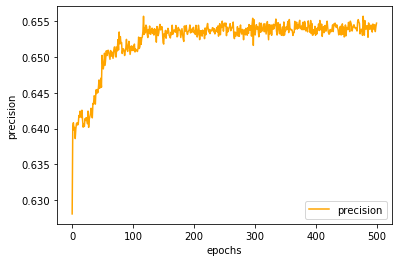

In [20]:
plt.plot(epochs, historia_modelo_4.history['precision_m'], color='orange', label='precision')
plt.xlabel("epochs")
plt.ylabel("precision")
plt.legend()

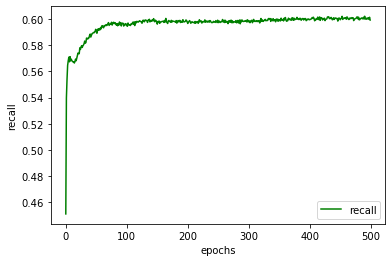

In [21]:
plt.plot(epochs, historia_modelo_4.history['recall_m'], color='green', label='recall')
plt.xlabel("epochs")
plt.ylabel("recall")
plt.legend()

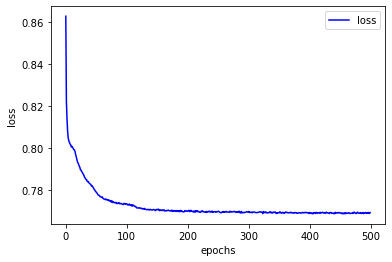

In [22]:
plt.plot(epochs, historia_modelo_4.history['loss'], color='blue', label='loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

In [23]:
y_predic = modelo_4.predict(x_test_scaled)

455/455 [==============================] - 1s 1ms/step


In [24]:
y_predic[0:5]

array([[1.06023885e-01, 1.14975444e-06, 8.93974960e-01],
       [1.62358119e-04, 1.50613550e-05, 9.99822617e-01],
       [1.51032279e-03, 7.93381512e-01, 2.05108240e-01],
       [1.05259765e-07, 3.16256583e-01, 6.83743179e-01],
       [3.63416108e-03, 8.30326617e-01, 1.66039199e-01]], dtype=float32)

In [25]:
#Arbol Reporte y Matriz de Confusion
y_predic1=np.argmax(y_predic,axis=1)
y_test_encoder1=np.argmax(y_test_encoder,axis=1)

print(classification_report(y_test_encoder1,y_predic1))

              precision    recall  f1-score   support

           0       0.61      0.02      0.04      3438
           1       0.31      0.45      0.37      3660
           2       0.52      0.64      0.57      7436

    accuracy                           0.45     14534
   macro avg       0.48      0.37      0.33     14534
weighted avg       0.49      0.45      0.40     14534



In [26]:
print('Accuracy: {}'.format(accuracy_score(y_test_encoder1, y_predic1))) 
print('Precision: {}'.format(precision_score(y_test_encoder1, y_predic1, average= 'micro'))) 
print('Recall: {}'.format(recall_score(y_test_encoder1, y_predic1, average= 'micro'))) 
print('F1-Score: {}'.format(f1_score(y_test_encoder1, y_predic1, average= 'micro'))) 

Accuracy: 0.4450254575478189
Precision: 0.4450254575478189
Recall: 0.4450254575478189
F1-Score: 0.4450254575478189


Obtenemos valores menores

# Conclusion
---


Obtuvimos mejores resultados con 3 capas, una de entrada con 8 neuronas, una oculta con 5 neuronas y una de salida con 3. 